In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import abel

In [2]:
def tri_area(p1,p2,p3):
    area = 0.5*np.abs(p1[0]*p2[1]+p2[0]*p3[1]+p3[0]*p1[1]-p2[0]*p1[1]-p3[0]*p2[1]-p1[0]*p3[1]) #Shoelace formula
    return area
def reduce_matrix(I):
    return (I[:I.shape[0]//2+1,:]+np.flip(I[I.shape[0]//2:,:],axis=0))/2

In [3]:
#Pixel and corresponding line of sight
#Assume 
class Image:
    def __init__(self,img,pixelsize):
        self.img = img
        self.size = np.shape(img)
        self.pixelsize = pixelsize
        self.pixels = self.set_pixels()
        self.boundaries = self.get_boundaries()
        
    def set_pixels(self):
        pixels = []
        for i in range(self.size[0]):
                pixels.append(Pixel(self.img[i],i,self.size[0],self.pixelsize))
        return pixels
    
    def get_boundaries(self):
        boundaries = np.zeros(self.size[0]+1)
        for i in range(self.size[0]):
            boundaries[i] = self.pixels[i].upper_boundary
        boundaries[self.size[0]] = self.pixels[-1].lower_boundary
        return boundaries
                
class Pixel:
    
    def __init__(self,value,index,imgsize,width):
        self.value = value
        self.index = index
        self.lower_boundary, self.upper_boundary = self.get_boundaries(imgsize,width)
        
    def get_boundaries(self,imgsize,width): #Coordinate boundaries of centered image, assume odd number of pixels
        center = int(imgsize/2)
        upper_boundary = (center-self.index+0.5)*width
        lower_boundary = (center-self.index-0.5)*width
        #upper_boundary = (imgsize-self.index)*width
        #lower_boundary = (imgsize-self.index-1)*width
        return lower_boundary, upper_boundary    

In [4]:
#Circular isolines in the right half-plane
class Isolines:
    
    def __init__(self,r_min,r_max,N,M):
        self.R = np.linspace(r_min,r_max,N)
        self.number_of_lines = N
        self.number_of_points_per_line = M
        self.phi_min = -np.pi/2
        self.phi_max = np.pi/2
        self.sample_points_polar = np.empty((0,2))
        self.sample_points_cartesian = np.empty((0,2))
        self.triangles = None
        self.triangle_areas = None
        self.triangle_cuts = dict()
                
    def sample(self):
        sample_points = [[0,0]] #origin r = 0, phi = 0
        for r in self.R[1:]:
            angles = np.linspace(self.phi_min,self.phi_max,self.number_of_points_per_line)
            sample_points.extend([r,phi] for phi in angles) #fix later, extend is slow
        self.sample_points_polar = np.array(sample_points)
        self.get_cartesian()
    
    def triangulate(self):
        self.triangles = tri.Triangulation(self.sample_points_cartesian[:,0], self.sample_points_cartesian[:,1])
        
    def calculate_matrix_elements(self,image):
        matrix = np.zeros((image.size[0],self.number_of_lines))
        self.calculate_triangle_areas()
        self.group_by_isolines()
        self.group_by_pixels(image)
        for i in range(self.triangles.triangles.shape[0]):
            m = self.pixel_indices[i]
            n = self.isoline_indices[i]
            if isinstance(m,list):
                if len(m)==2:
                    for j in n:
                        matrix[m[0],j] += 1/3.0*(self.triangle_cuts[i])
                        matrix[m[1],j] += 1/3.0*(self.triangle_areas[i] - self.triangle_cuts[i])
                else:
                    for j in n:
                        matrix[m[0],j] += 1/3.0*(self.triangle_cuts[i][0])
                        matrix[m[1],j] += 1/3.0*(self.triangle_areas[i]-self.triangle_cuts[i][0]-self.triangle_cuts[i][1])
                        matrix[m[2],j] += 1/3.0*(self.triangle_cuts[i][1])
            else:
                for j in n:
                    matrix[m,j] += 1/3.0*(self.triangle_areas[i])
        return 2*matrix/image.pixelsize
        
        
    def calculate_triangle_areas(self):
        self.triangle_areas = np.zeros(self.triangles.triangles.shape[0])
        for i in range(self.triangles.triangles.shape[0]):
            self.triangle_areas[i] = tri_area(*self.sample_points_cartesian[self.triangles.triangles[i]])
    
    def group_by_isolines(self):
        self.isoline_indices = [None] * self.triangles.triangles.shape[0]
        for i in range(self.triangles.triangles.shape[0]):
            radii = self.sample_points_polar[self.triangles.triangles[i]][:,0]
            #base attribution scheme
            #unique, counts = np.unique(radii, return_counts=True)
            #attributed_radius = unique[counts==2][0]
            #self.isoline_indices[i] = int((self.number_of_lines-1) * attributed_radius/(self.R[self.number_of_lines-1]-self.R[0]))
            
            #simple average scheme
            indices = (self.number_of_lines-1) * radii/(self.R[self.number_of_lines-1]-self.R[0])
            #if self.R[5] in radii:
            #    print(i,radii,indices,list(map(round,indices)))
            self.isoline_indices[i] = list(map(round,indices))
            
            
    def group_by_pixels(self,image):
        self.pixel_indices = [None] * self.triangles.triangles.shape[0]
        for i in range(self.triangles.triangles.shape[0]):
            self.pixel_indices[i] = self.find_pixel(i, self.triangles.triangles[i], image)
        
    def find_pixel(self, triangle_index, triangle, image):
        y_coords = self.sample_points_cartesian[triangle][:,1]
        bounds = -image.boundaries #flip order from descending to ascending
        indices = np.searchsorted(bounds,-y_coords) #flip sign as above
        indices = np.where(indices != 0, indices, 1)
        unique_indices, index_positions, counts = np.unique(indices,return_index=True,return_counts=True)
        if unique_indices.shape[0]==1:
            return unique_indices[0]-1
        elif unique_indices.shape[0] == 2:
            if unique_indices[1]-unique_indices[0] > 1:
                print("Error1") #If that error occurs, increase M
            else:
                tip_pos = index_positions[counts==1][0]
                area = self.cut_by_pixel(triangle_index, triangle, unique_indices[0], tip_pos, image) #cut by pixel and calculate area of subtriangle
                self.triangle_cuts.update({triangle_index:area})
                return [unique_indices[counts==1][0]-1,unique_indices[counts==2][0]-1] #put tip index first so that the mapping of the subarea to the pixel is clear and doesn't need to be stored as extra information
        else:
            #return 0
            if np.any(np.diff(unique_indices)>1):
                print("Error") #If that error occurs, increase M
            else:
                tip_pos1 = index_positions[0]
                tip_pos2 = index_positions[2]
                area1 = self.cut_by_pixel(triangle_index, triangle, unique_indices[0], tip_pos1, image)
                area2 = self.cut_by_pixel(triangle_index, triangle, unique_indices[1], tip_pos2, image)
                #print((self.triangle_areas[triangle_index]-area1-area2)/self.triangle_areas[triangle_index]*100)
                self.triangle_cuts.update({triangle_index:[area1,area2]})
                return list(unique_indices-1)
        
    def cut_by_pixel(self, triangle_index, triangle, border_index, tip_pos, image):
        #Identify tip point and base points
        mask = np.ones(3,bool)
        mask[tip_pos] = False
        tip = self.sample_points_cartesian[triangle][tip_pos]
        base1 = self.sample_points_cartesian[triangle][mask][0]
        base2 = self.sample_points_cartesian[triangle][mask][1]
        
        #Calculate intersection points
        bound = image.boundaries[border_index]
        t1 = (bound - base1[1])/(tip[1]-base1[1])
        t2 = (bound - base2[1])/(tip[1]-base2[1])
        p1 = np.array([t1 * tip[0] + (1-t1) * base1[0],bound])
        p2 = np.array([t2 * tip[0] + (1-t2) * base2[0],bound])
        
        #calculate area of tip-intersection-intersection triangle
        return tri_area(tip,p1,p2)

    def get_cartesian(self):
        self.sample_points_cartesian = np.zeros((self.sample_points_polar.shape[0],2))
        for i in range(self.sample_points_polar.shape[0]):
            r = self.sample_points_polar[i][0]
            phi = self.sample_points_polar[i][1]
            self.sample_points_cartesian[i][0] = r*np.cos(phi)
            self.sample_points_cartesian[i][1] = r*np.sin(phi)

In [7]:
print(I.shape,I_reduced.shape)

(19, 10) (10, 10)


In [8]:
N=10 #number of isolines, number of independent pixels
M=50
frame = Image(np.zeros(2*N-1),1.0/(N-1))
circs = Isolines(0,1,N,M)
circs.sample()
circs.triangulate()
P = circs.sample_points_cartesian
I = circs.calculate_matrix_elements(frame)
I_reduced = reduce_matrix(I)

In [9]:
I.sum()*frame.pixelsize-np.pi*circs.R[-1]

-0.002151874534860543

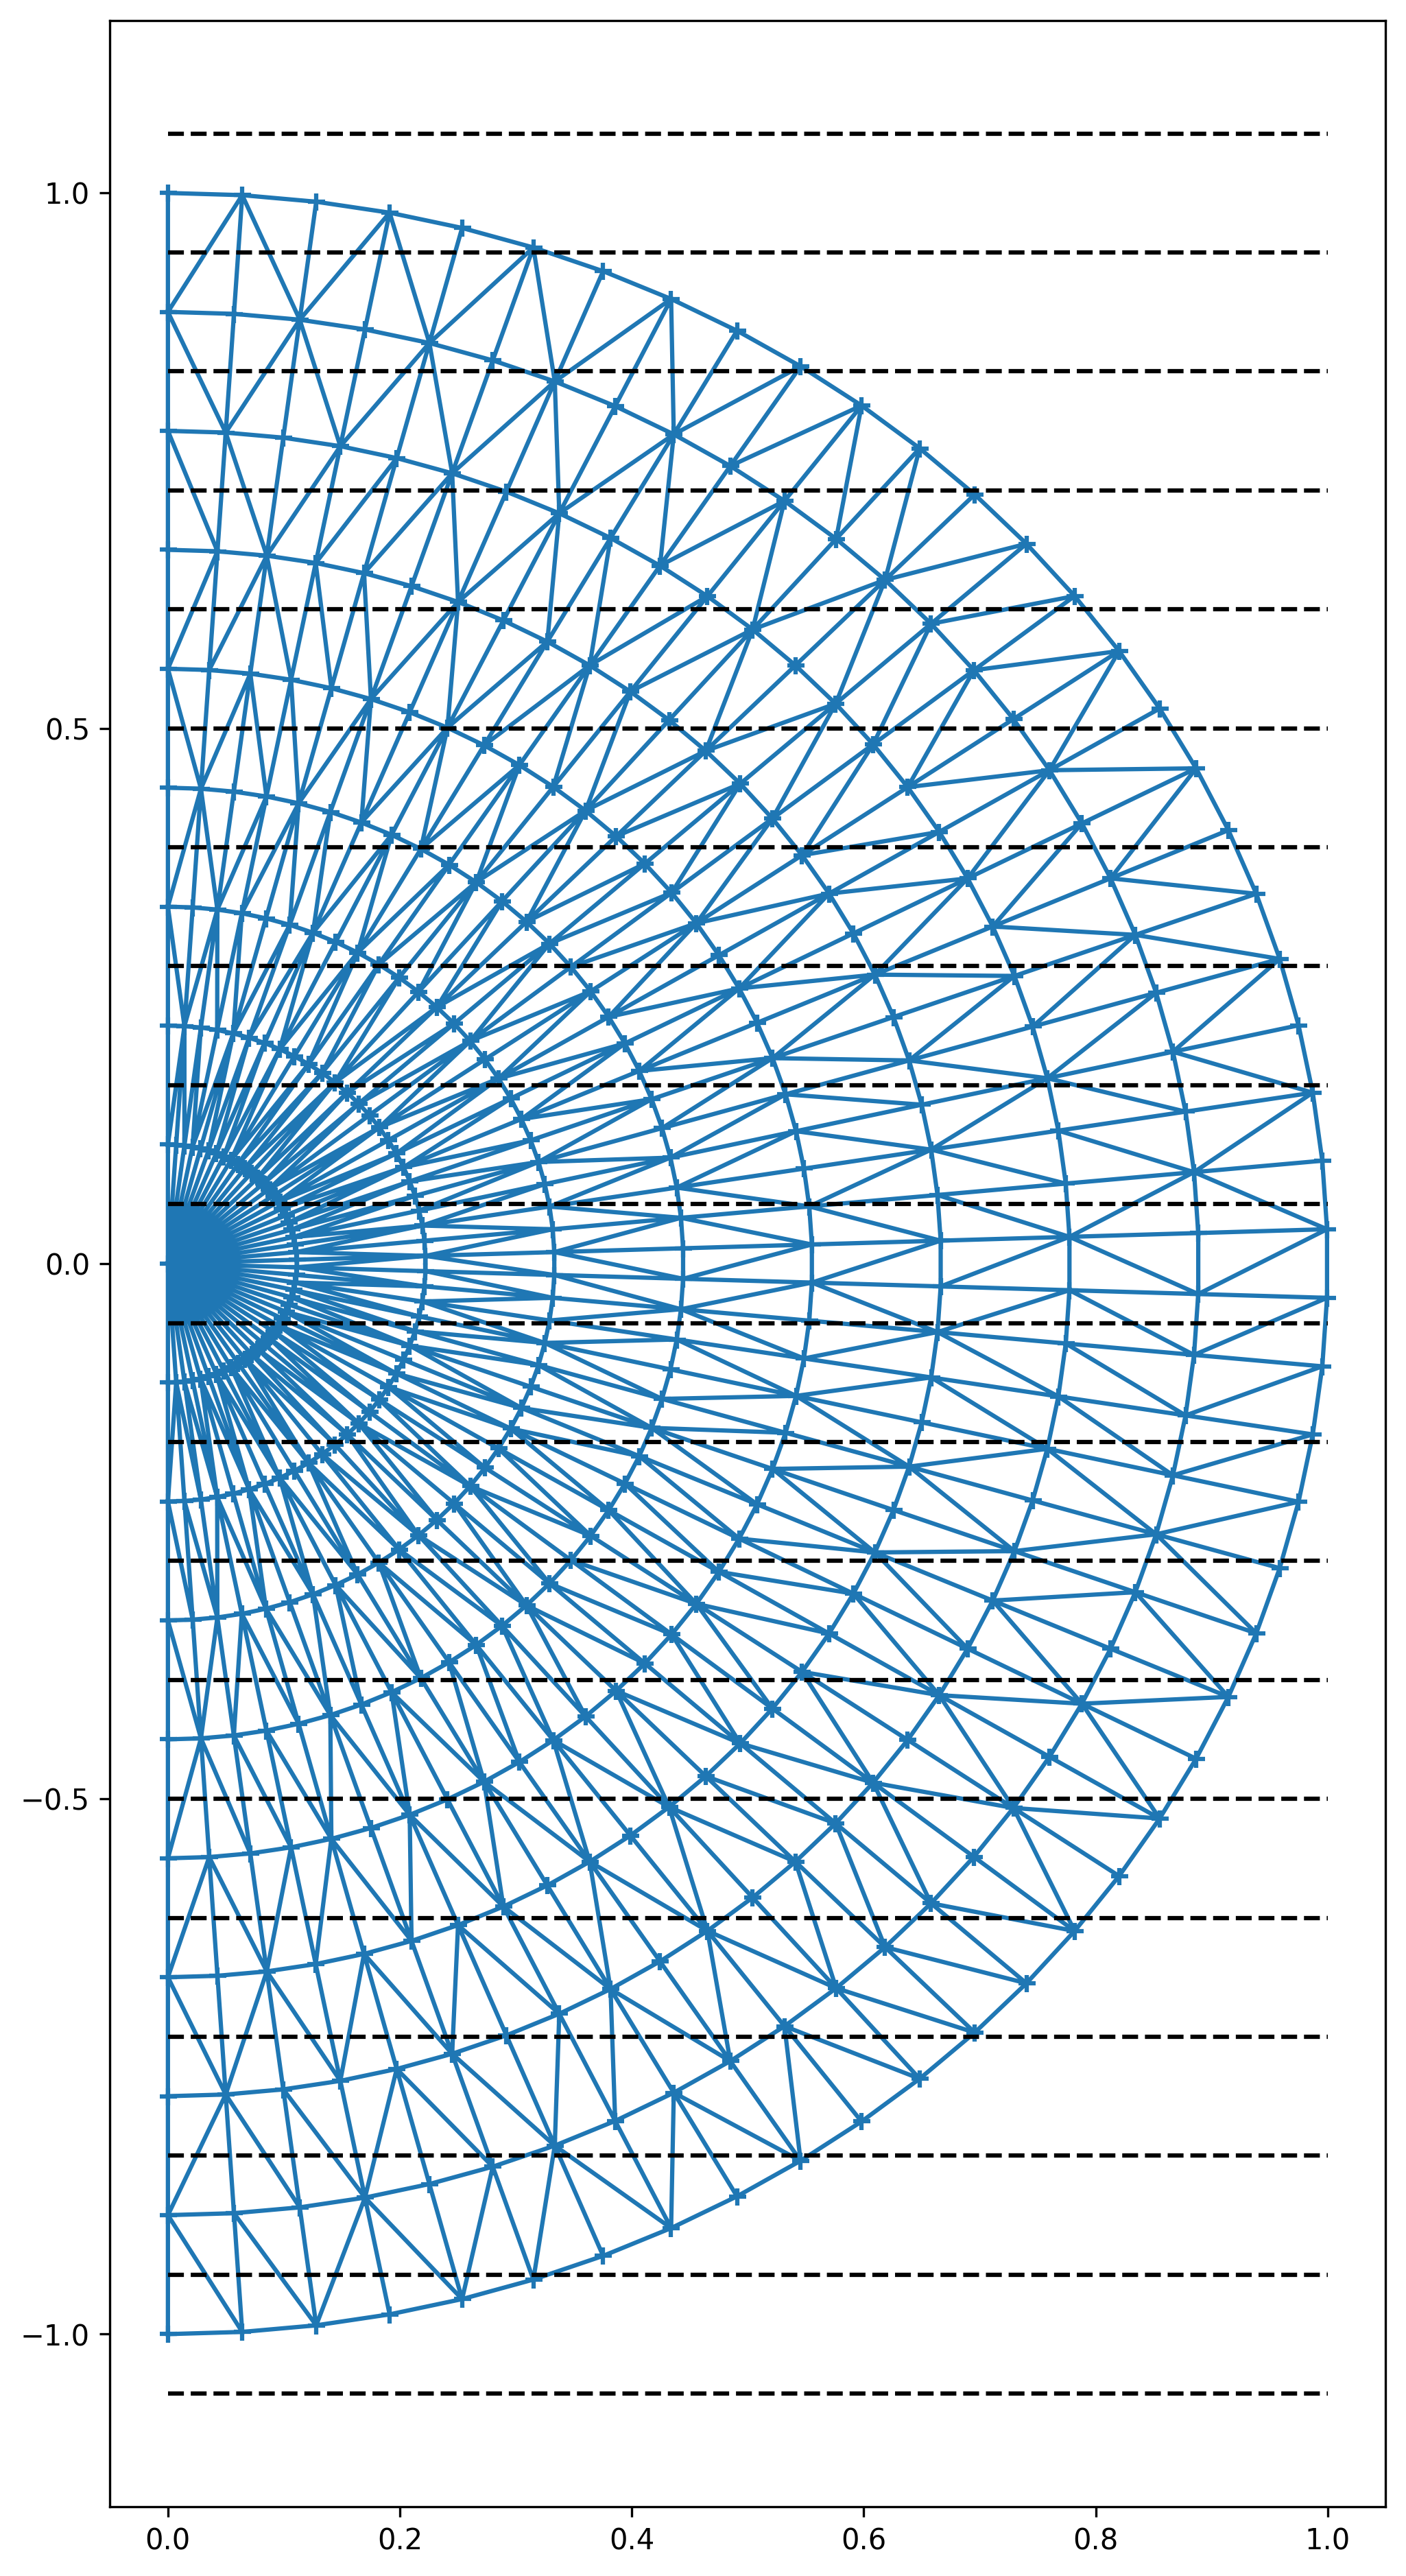

In [10]:
plt.figure(figsize=(8, 16),dpi=300)
plt.scatter(P[:,0],P[:,1],marker = '+')
for bound in frame.get_boundaries():
    plt.plot([0,1],[bound,bound],color = 'black', ls = '--')
plt.triplot(circs.triangles)
#plt.scatter(P[394][0],P[394][1],color='red', marker = 'o', s = 50)
#plt.scatter(P[445][0],P[445][1],color='red', marker = 'o', s = 50)
#plt.scatter(P[395][0],P[395][1],color='red', marker = 'o', s = 50)
#plt.scatter(0.54174426, 0.63636364,color='orange',marker='x',s=20)
#plt.scatter(0.52336735, 0.63636364,color='orange',marker='x',s=20)
#plt.xlim(0.9,1)
#plt.ylim(-0.4,-0.32)
plt.savefig('Triangulation')
plt.show()

In [373]:
I_reduced = I_reduced[1:,:-1]

In [6]:
with np.printoptions(precision=2, suppress=True):
    print(I_reduced)

[[0.   0.   0.   0.   0.   0.   0.   0.   0.09 0.13]
 [0.   0.   0.   0.   0.   0.   0.   0.08 0.48 0.35]
 [0.   0.   0.   0.   0.   0.   0.08 0.45 0.53 0.2 ]
 [0.   0.   0.   0.   0.   0.07 0.41 0.5  0.34 0.16]
 [0.   0.   0.   0.   0.06 0.38 0.46 0.33 0.29 0.14]
 [0.   0.   0.   0.06 0.34 0.42 0.31 0.28 0.26 0.13]
 [0.   0.   0.05 0.3  0.38 0.28 0.26 0.25 0.24 0.12]
 [0.   0.04 0.25 0.34 0.26 0.25 0.24 0.23 0.23 0.12]
 [0.02 0.19 0.29 0.24 0.23 0.23 0.22 0.23 0.22 0.11]
 [0.07 0.25 0.23 0.23 0.22 0.22 0.23 0.21 0.24 0.1 ]]


In [7]:
with np.printoptions(precision=2, suppress=True):
    print((I[:I.shape[0]//2+1,:]+np.flip(I[I.shape[0]//2:,:],axis=0))/2)

[[0.   0.   0.   0.   0.   0.   0.   0.   0.09 0.13]
 [0.   0.   0.   0.   0.   0.   0.   0.08 0.48 0.35]
 [0.   0.   0.   0.   0.   0.   0.08 0.45 0.53 0.2 ]
 [0.   0.   0.   0.   0.   0.07 0.41 0.5  0.34 0.16]
 [0.   0.   0.   0.   0.06 0.38 0.46 0.33 0.29 0.14]
 [0.   0.   0.   0.06 0.34 0.42 0.31 0.28 0.26 0.13]
 [0.   0.   0.05 0.3  0.38 0.28 0.26 0.25 0.24 0.12]
 [0.   0.04 0.25 0.34 0.26 0.25 0.24 0.23 0.23 0.12]
 [0.02 0.19 0.29 0.24 0.23 0.23 0.22 0.23 0.22 0.11]
 [0.07 0.25 0.23 0.23 0.22 0.22 0.23 0.21 0.24 0.1 ]]


In [11]:
with np.printoptions(precision=2, suppress=True):
    print(((I[I.shape[0]//2:,:])))

[[0.07 0.25 0.23 0.23 0.22 0.22 0.23 0.21 0.24 0.1 ]
 [0.02 0.19 0.29 0.24 0.23 0.23 0.22 0.23 0.22 0.11]
 [0.   0.04 0.25 0.34 0.26 0.25 0.24 0.24 0.22 0.12]
 [0.   0.   0.05 0.3  0.38 0.28 0.26 0.25 0.25 0.12]
 [0.   0.   0.   0.06 0.34 0.42 0.31 0.28 0.26 0.13]
 [0.   0.   0.   0.   0.06 0.38 0.46 0.33 0.3  0.14]
 [0.   0.   0.   0.   0.   0.07 0.41 0.5  0.35 0.16]
 [0.   0.   0.   0.   0.   0.   0.08 0.45 0.53 0.2 ]
 [0.   0.   0.   0.   0.   0.   0.   0.08 0.48 0.35]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.09 0.13]]


In [8]:
with np.printoptions(precision=2, suppress=True):
        print(I)

[[0.   0.   0.   0.   0.   0.   0.   0.   0.09 0.13]
 [0.   0.   0.   0.   0.   0.   0.   0.08 0.48 0.35]
 [0.   0.   0.   0.   0.   0.   0.07 0.45 0.53 0.2 ]
 [0.   0.   0.   0.   0.   0.07 0.42 0.49 0.34 0.17]
 [0.   0.   0.   0.   0.06 0.38 0.46 0.33 0.29 0.13]
 [0.   0.   0.   0.06 0.34 0.42 0.3  0.28 0.26 0.13]
 [0.   0.   0.05 0.3  0.38 0.28 0.26 0.25 0.24 0.12]
 [0.   0.04 0.25 0.34 0.26 0.24 0.24 0.22 0.23 0.12]
 [0.02 0.19 0.29 0.24 0.23 0.23 0.22 0.24 0.21 0.11]
 [0.07 0.25 0.23 0.23 0.22 0.22 0.23 0.21 0.24 0.1 ]
 [0.02 0.19 0.29 0.24 0.23 0.23 0.22 0.23 0.22 0.11]
 [0.   0.04 0.25 0.34 0.26 0.25 0.24 0.24 0.22 0.12]
 [0.   0.   0.05 0.3  0.38 0.28 0.26 0.25 0.25 0.12]
 [0.   0.   0.   0.06 0.34 0.42 0.31 0.28 0.26 0.13]
 [0.   0.   0.   0.   0.06 0.38 0.46 0.33 0.3  0.14]
 [0.   0.   0.   0.   0.   0.07 0.41 0.5  0.35 0.16]
 [0.   0.   0.   0.   0.   0.   0.08 0.45 0.53 0.2 ]
 [0.   0.   0.   0.   0.   0.   0.   0.08 0.48 0.35]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.09

In [12]:
with np.printoptions(precision=2, suppress=True):
        print(I)
        print(I[1:,:-1])

[[0.   0.   0.   0.   0.   0.   0.   0.   0.09 0.13]
 [0.   0.   0.   0.   0.   0.   0.   0.08 0.48 0.35]
 [0.   0.   0.   0.   0.   0.   0.07 0.45 0.53 0.2 ]
 [0.   0.   0.   0.   0.   0.07 0.42 0.49 0.34 0.17]
 [0.   0.   0.   0.   0.06 0.38 0.46 0.33 0.29 0.13]
 [0.   0.   0.   0.06 0.34 0.42 0.3  0.28 0.26 0.13]
 [0.   0.   0.05 0.3  0.38 0.28 0.26 0.25 0.24 0.12]
 [0.   0.04 0.25 0.34 0.26 0.24 0.24 0.22 0.23 0.12]
 [0.02 0.19 0.29 0.24 0.23 0.23 0.22 0.24 0.21 0.11]
 [0.07 0.25 0.23 0.23 0.22 0.22 0.23 0.21 0.24 0.1 ]
 [0.02 0.19 0.29 0.24 0.23 0.23 0.22 0.23 0.22 0.11]
 [0.   0.04 0.25 0.34 0.26 0.25 0.24 0.24 0.22 0.12]
 [0.   0.   0.05 0.3  0.38 0.28 0.26 0.25 0.25 0.12]
 [0.   0.   0.   0.06 0.34 0.42 0.31 0.28 0.26 0.13]
 [0.   0.   0.   0.   0.06 0.38 0.46 0.33 0.3  0.14]
 [0.   0.   0.   0.   0.   0.07 0.41 0.5  0.35 0.16]
 [0.   0.   0.   0.   0.   0.   0.08 0.45 0.53 0.2 ]
 [0.   0.   0.   0.   0.   0.   0.   0.08 0.48 0.35]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.09

## Test Abel transform

In [34]:
# Analytical inverse Abel: 
n = 65
r_max = 10
sigma = 5

ref = abel.tools.analytical.GaussianAnalytical(n, r_max, sigma,symmetric=False)

In [35]:
m=1000
frame = Image(np.zeros(2*n-1),10/(n-1))
circs = Isolines(0,10,n,m)
circs.sample()
P = circs.sample_points_cartesian
circs.triangulate()
I=circs.calculate_matrix_elements(frame)
I = reduce_matrix(I)

In [36]:
I.shape

(65, 65)

In [44]:
func=np.exp(-circs.R[:-1]**2/sigma**2)

In [38]:
I.sum()*frame.pixelsize-np.pi/2*100

1.562223906790365

In [46]:
np.linalg.cond(I)

850.3030617258308

In [45]:
I = I[1:,:-1]

In [47]:
I.shape

(64, 64)

In [48]:
inv=np.linalg.inv(I)

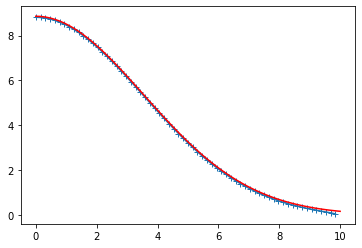

In [50]:
plt.plot(ref.r[:-1],np.flip(I@func),marker='+')
plt.plot(ref.r, ref.abel, color='r')

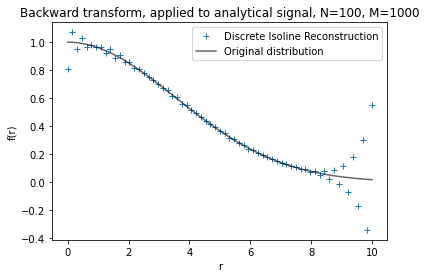

In [43]:
plt.plot(ref.r,inv@(np.flip(ref.abel)),marker='+',ms=6,ls='None',label='Discrete Isoline Reconstruction')
plt.plot(ref.r,func,color='black',alpha=0.6,label='Original distribution')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.title('Backward transform, applied to analytical signal, N=100, M=1000')
plt.show()

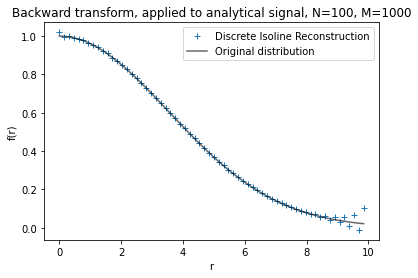

In [51]:
plt.plot(ref.r[:-1],inv@(np.flip(ref.abel)[1:]),marker='+',ms=6,ls='None',label='Discrete Isoline Reconstruction')
plt.plot(ref.r[:-1],func,color='black',alpha=0.6,label='Original distribution')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.title('Backward transform, applied to analytical signal, N=100, M=1000')
plt.show()

## Noise

In [40]:
pure_signal = I@func
noise_ratio = 0.02
noise = pure_signal.std() * noise_ratio * np.random.normal(0,1,pure_signal.shape[0])
#noise = np.flip(np.sort(noise))

noisy_signal = pure_signal + noise

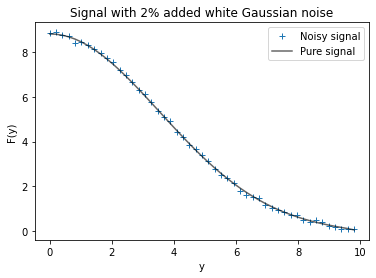

In [41]:
plt.plot(ref.r[:-1],np.flip(noisy_signal),marker='+',ms=6,ls='None',label='Noisy signal')
plt.plot(ref.r[:-1],np.flip(pure_signal),color='black',alpha=0.6,label='Pure signal')
plt.xlabel('y')
plt.ylabel('F(y)')
plt.legend()
plt.title('Signal with 2% added white Gaussian noise')
#plt.savefig('Noise')
plt.show()

A suitable basis set was not found.
A new basis set will be generated.
This may take a few minutes.
Generating horizontal BASEX basis sets for n = 49, sigma = 1.0 (nbf = 49):
k = 0...49
Updating regularization...
Calculating correction...


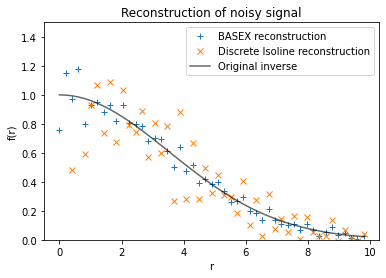

In [42]:
recon = abel.basex.basex_transform(np.flip(noisy_signal), verbose=True, basis_dir=None, dr = ref.dr, direction='inverse')
plt.plot(ref.r[:-1],recon,marker='+',ms=6,ls='None',label='BASEX reconstruction')
plt.plot(ref.r[:-1],inv@noisy_signal,marker='x',ms=6,ls='None',label='Discrete Isoline reconstruction')
plt.plot(ref.r[:-1],func,color='black',alpha=0.6,label='Original inverse')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.ylim(0,1.5)
plt.title('Reconstruction of noisy signal')
plt.savefig('Noise-Reconstruction')
plt.show()

In [43]:
np.linalg.cond(I)

648.720252814762